### Logistic Regression

Machine Learning Algorithms

Dates: 2022-3-11

Author: Yung-Kyun Noh

Department of Computer Science, Hanyang University & KIAS


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def draw_state(wval, bval, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0
    
    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data1[:,0], data1[:,1], label='class 1', c='red', alpha=.3)
    ax.scatter(data2[:,0], data2[:,1], label='class 2', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()
    
    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


In [3]:
def logistic_function(t):
    # example: logistic_function(np.array([0,1,2]))
    
    ret_val = 1/(1 + np.exp(-t))
    return ret_val

In [4]:
def get_loss(labels, fs):
    loss_val = np.sum(labels*np.log(fs) + (1 - labels)*np.log(1 - fs))
    return loss_val

### Data generation

In [5]:
# generate two Gaussians (class 1 & class 2)
dim = 2
datanum1 = 50
datanum2 = 50
mean1 = np.array([0, 0])
mean2 = np.array([1, -.5])
cov1 = np.array([[.1,.02],[.02,.1]])
cov2 = np.array([[.1,.02],[.02,.1]])
data1 = np.random.multivariate_normal(mean1, cov1, datanum1)
data2 = np.random.multivariate_normal(mean2, cov2, datanum2)
tstdatanum1 = 100
tstdatanum2 = 100
tstdata1 = np.random.multivariate_normal(mean1, cov1, tstdatanum1)
tstdata2 = np.random.multivariate_normal(mean2, cov2, tstdatanum2)


### Optimal Bayes classifier

When the data generating functions are Gaussians having the equivalent covariances, we can obtain the optimal linear classifier.

[-11.45833333   7.29166667] -7.552083333333334


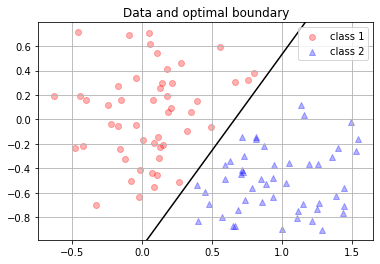

In [6]:
# optimal linear classifier
optw = np.matmul(mean1 - mean2, np.linalg.inv(cov1))
optb = np.matmul(optw, (mean1 + mean2)/2)
print(optw, optb)

draw_state(optw, optb, data1, data2, 'Data and optimal boundary')

### Learning

In [7]:
def update_w(w_init, b_init, data1, data2, num_update=100, step_size=0.001, reg_const=1):
    # extended w: [w, -b]
    extw = np.array([np.concatenate((w_init, -b_init))])
    # data with '1' is appended: [X, 1]
    extX = np.concatenate((np.concatenate((data1, data2), axis=0), \
                       np.ones([datanum1 + datanum2, 1])), axis=1)
    labels = np.concatenate((np.ones(datanum1), np.zeros(datanum2)))  # label of class 1: 1, label of class 2: 0

    #     print(extw)
    draw_state(extw[0,0:2], -extw[0,2], data1, data2, 'Before update')

    objective_history = []
    for i in range(num_update):
        ts = np.matmul(extX, extw.T)  # w^TX
        fs = logistic_function(ts)
        extw = extw + step_size*(np.matmul(np.array([labels]) - fs.T, extX) - reg_const*extw)
        objective_history.append(get_loss(labels, fs.T[0]))

    draw_state(extw[0,0:2], -extw[0,2], data1, data2, 'Updated boundary')
    
    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")
    
    return extw[0,0:2], np.array([-extw[0,2]])


In [8]:
# Initialize parameters
w_init = np.random.normal(0,1,dim)
b_init = np.random.normal(0,1,1)

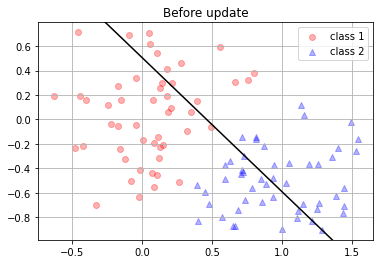

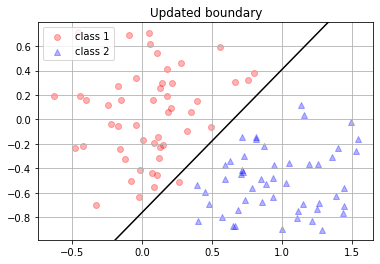

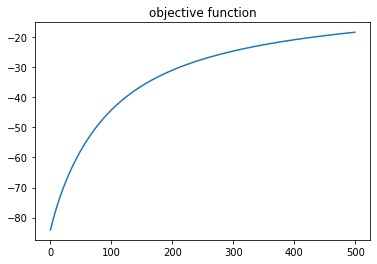

In [9]:
cur_w, cur_b = update_w(w_init, b_init, data1, data2, num_update=500, step_size=0.001, reg_const=0)

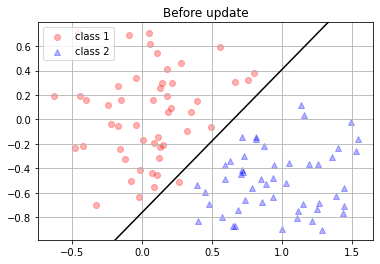

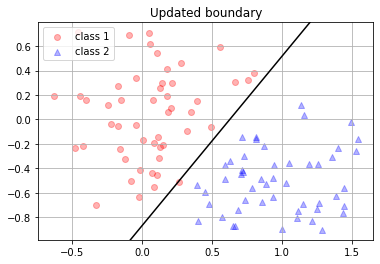

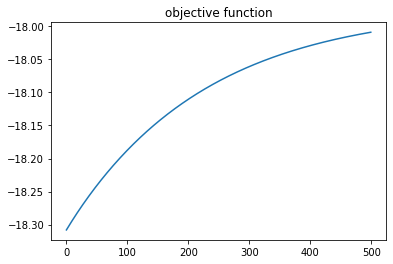

In [10]:
# Additional 100 updates
cur_w, cur_b = update_w(cur_w, cur_b, data1, data2, num_update=500)

#### Evaluation

In [11]:
TstLabels = np.concatenate((np.ones(tstdatanum1), np.zeros(tstdatanum2)))

ts = np.matmul(np.concatenate((tstdata1, tstdata2)), cur_w) - cur_b  # w^TX - b
err_rate = np.sum(np.abs((ts > 0) - np.array([TstLabels])))/(tstdatanum1 + tstdatanum2)
print(err_rate)

0.045


## Learning using Keras

In [12]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras

x_train = np.concatenate((data1, data2), axis=0)
y_train = np.concatenate((np.ones(datanum1), np.zeros(datanum2)))  # label of class 1: 1, label of class 2: 0
x_test = np.concatenate((tstdata1, tstdata2), axis=0)
y_test = np.concatenate((np.ones(tstdatanum1), np.zeros(tstdatanum2)))


### Keras implementation

In [13]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras

In [14]:
x_train = np.concatenate((data1, data2), axis=0)
y_train = np.concatenate((np.ones(datanum1), np.zeros(datanum2)))  # label of class 1: 1, label of class 2: 0
x_test = np.concatenate((tstdata1, tstdata2), axis=0)
y_test = np.concatenate((np.ones(tstdatanum1), np.zeros(tstdatanum2)))


In [15]:
model = Sequential()
model.add(Dense(units=1, activation='sigmoid', input_shape=(2,), kernel_regularizer=keras.regularizers.l2(0.1)))   # caution: not 'softmax' or 'relu'
model.summary()

model.compile(loss='binary_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(x_train, y_train,
                    epochs=500,
                    verbose=1,
                    validation_data=(x_test, y_test))


Epoch 1/500
4/4 [==============================] - 4s 90ms/step - loss: 1.0443 - accuracy: 0.2600 - val_loss: 1.0246 - val_accuracy: 0.3000
Epoch 2/500
4/4 [==============================] - 0s 20ms/step - loss: 1.0384 - accuracy: 0.2600 - val_loss: 1.0209 - val_accuracy: 0.3000
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 1.0349 - accuracy: 0.2600 - val_loss: 1.0177 - val_accuracy: 0.3000
Epoch 4/500
4/4 [==============================] - 0s 20ms/step - loss: 1.0318 - accuracy: 0.2600 - val_loss: 1.0144 - val_accuracy: 0.3000
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 1.0287 - accuracy: 0.2600 - val_loss: 1.0116 - val_accuracy: 0.3100
Epoch 6/500
4/4 [==============================] - 0s 20ms/step - loss: 1.0261 - accuracy: 0.2600 - val_loss: 1.0089 - val_accuracy: 0.3200
Epoch 7/500
4/4 [==============================] - 0s 18ms/step - loss: 1.0233 - accuracy: 0.2700 - val_loss: 1.0058 - val_accuracy: 0.3200
Epoch 8/500
4/4 [===

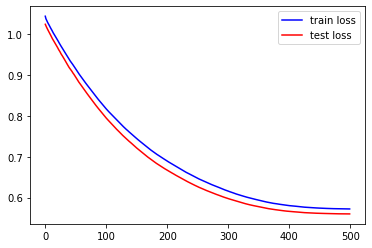

In [17]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], 'b', label='train loss')
ax.plot(history.history['val_loss'], 'r', label='test loss')
ax.legend()

w param: 
 <tf.Variable 'dense/kernel:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.76596177],
       [ 0.4306572 ]], dtype=float32)> 

b param: 
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.39752972], dtype=float32)>


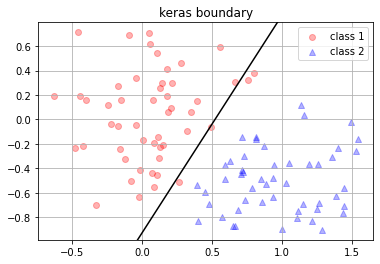

In [18]:
print('w param: \n', model.weights[0], '\n\nb param: \n', model.weights[1])

draw_state(model.weights[0].numpy(), -model.weights[1].numpy(), data1, data2, 'keras boundary')


### Watch derivatives

Example: calculate the derivative of a function with respect to a vector
\begin{eqnarray}
f(\mathbf{w}) &=& \mathbf{w}^\top \mathbf{x} \in\mathbb{R} \quad \text{for} \quad \mathbf{w}, \mathbf{x} \in \mathbb{R}^2 \\
&& \text{then} \quad \frac{df}{d\mathbf{w}} = ?
\end{eqnarray}

In [19]:
import tensorflow as tf

In [20]:
x = tf.Variable(tf.constant([[2],[3]], dtype='float'))
w = tf.Variable(tf.constant([[0],[0]], dtype='float'))
with tf.GradientTape() as tape:
    f = tf.matmul(tf.transpose(w), x)

df_dw = tape.gradient(f, w)
print('derivative=', df_dw.numpy().T, '\nx=', x.numpy().T)

derivative= [[2. 3.]] 
x= [[2. 3.]]


### Taking gradients of your parameters

In [21]:
# gradient of outputs

x = np.array([[1,0]])
with tf.GradientTape() as tape:
    model = Sequential([
        Dense(units=1, activation='sigmoid')
    ])
    fx = model(x)

df_dw = tape.gradient(fx, model.weights)   # Derivative of (f at x) w.r.t. weights at the current weights
print('f=', f)
print('\ndf/dw=\n', df_dw[0].numpy(), ' for w,\nand\n', df_dw[1].numpy(), 'for b')

f= tf.Tensor([[0.]], shape=(1, 1), dtype=float32)

df/dw=
 [[0.17396441]
 [0.        ]]  for w,
and
 [0.17396441] for b


In [22]:
# gradient of losses
# gradient for trainable_variables

layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
x = x_train

with tf.GradientTape() as tape:
    # Forward pass
    y = layer(x)   # weights are initialized here
    loss = tf.reduce_mean((tf.transpose(y) - y_train)**2 )
    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(loss, layer.trainable_variables)

print('loss:', loss)
print('\ngrad for w:\n', grad[0]) # for w and b separately
print('\ngrad for b:\n', grad[1]) # for w and b separately


loss: tf.Tensor(0.16649784, shape=(), dtype=float32)

grad for w:
 tf.Tensor(
[[ 0.03508979]
 [-0.0269244 ]], shape=(2, 1), dtype=float32)

grad for b:
 tf.Tensor([-0.07218707], shape=(1,), dtype=float32)


In [23]:
# Logistic regression learning

def tf_get_loss(labels, fs):
    loss_val = -1*tf.math.reduce_sum(labels*tf.math.log(fs) + (1 - labels)*tf.math.log(1 - fs))
    return loss_val

layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
n_iteration = 500
step_size = 0.001
reg_const = 0.05
for iiter in range(n_iteration):
    with tf.GradientTape() as tape:
        ys = layer(x_train)   # weights are initialized at first call
        loss = tf_get_loss(y_train, tf.transpose(ys)[0])

    # Calculate gradients with respect to every trainable variable
    grad = tape.gradient(loss, layer.trainable_variables)
    if iiter == 0:
        print('weights at start:\nw:\n', layer.weights[0].numpy(), '\nb:\n', layer.weights[1].numpy(), '\n')

    # Update the weights in our linear layer.
    layer.weights[0].assign(layer.weights[0] - step_size*grad[0] - reg_const*layer.weights[0])
    layer.weights[1].assign(layer.weights[1] - step_size*grad[1])
    if iiter % 100 == 0:
        print('loss:', loss.numpy())

print('\nweights at finish:\nw:\n', layer.weights[0].numpy(),'\nb:\n', layer.weights[1].numpy())


weights at start:
w:
 [[0.32607055]
 [0.6717135 ]] 
b:
 [0.] 

loss: 68.460915
loss: 58.56752
loss: 58.288742
loss: 58.25535
loss: 58.251152

weights at finish:
w:
 [[-0.3867287 ]
 [ 0.23107119]] 
b:
 [0.24973966]


w param: 
 [[-0.3867287 ]
 [ 0.23107119]] 

b param: 
 [0.24973966]


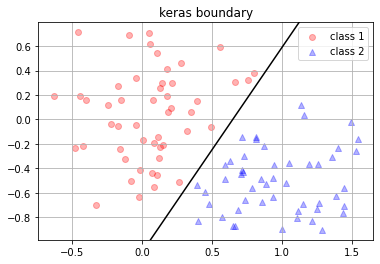

In [24]:
print('w param: \n', layer.weights[0].numpy(), '\n\nb param: \n', layer.weights[1].numpy())

draw_state(layer.weights[0].numpy(), -layer.weights[1].numpy(), data1, data2, 'keras boundary')


### Multilayer Neural Networks

In [25]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(x_train, y_train,
                    epochs=500,
                    verbose=1,
                    validation_data=(x_test, y_test))


Epoch 1/500
4/4 [==============================] - 1s 75ms/step - loss: 1.1747 - accuracy: 0.3000 - val_loss: 1.2113 - val_accuracy: 0.2400
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 1.1694 - accuracy: 0.3000 - val_loss: 1.2069 - val_accuracy: 0.2400
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 1.1655 - accuracy: 0.3000 - val_loss: 1.2030 - val_accuracy: 0.2350
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1618 - accuracy: 0.3000 - val_loss: 1.1993 - val_accuracy: 0.2350
Epoch 5/500
4/4 [==============================] - 0s 17ms/step - loss: 1.1584 - accuracy: 0.2800 - val_loss: 1.1972 - val_accuracy: 0.2350
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1564 - accuracy: 0.2800 - val_loss: 1.1944 - val_accuracy: 0.2350
Epoch 7/500
4/4 [==============================] - 0s 18ms/step - loss: 1.1538 - accuracy: 0.2800 - val_loss: 1.1916 - val_accuracy: 0.2350
Epoch 8/500
4/4 [===

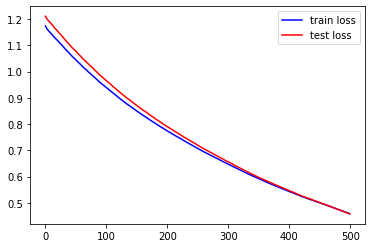

In [27]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], 'b', label='train loss')
ax.plot(history.history['val_loss'], 'r', label='test loss')
ax.legend()